**Install and import needed Libraries**

In [1]:
!pip install -U accelerate

In [2]:
!pip install transformers tokenizers
!pip install datasets


In [3]:
!pip install emoji

In [4]:
from datasets import Dataset
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer, RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import WeightedRandomSampler
from google.colab import files
from torch import nn
from collections import Counter
import emoji
import re
from transformers import pipeline
from tqdm import tqdm
import random
from transformers import EarlyStoppingCallback
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [5]:

uploaded = files.upload('olid-training-v1.0.tsv')

Saving olid-training-v1.0.tsv to olid-training-v1.0.tsv/olid-training-v1.0 (3).tsv


# EDA

**Code for data exploration**

In [6]:
df = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")


In [7]:
subtask_a_counts = df['subtask_a'].value_counts()
subtask_b_counts = df[df['subtask_a'] == 'OFF']['subtask_b'].value_counts()
subtask_c_counts = df[df['subtask_b'] == 'TIN']['subtask_c'].value_counts()
print(subtask_a_counts)
print(subtask_b_counts)
print(subtask_c_counts)

subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64
subtask_b
TIN    3876
UNT     524
Name: count, dtype: int64
subtask_c
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64


In [8]:
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<ipython-input-9-fdb74908188f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subtask_a_counts.index, y=subtask_a_counts.values, palette="Blues_d")


Text(0, 0.5, 'Count')

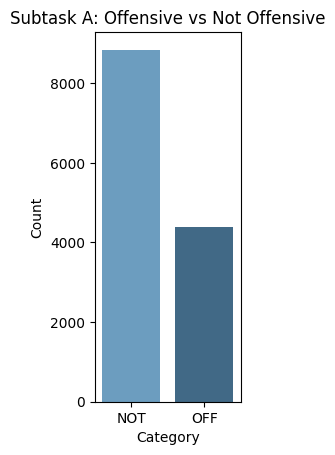

In [9]:
plt.subplot(1, 3, 1)
sns.barplot(x=subtask_a_counts.index, y=subtask_a_counts.values, palette="Blues_d")
plt.title("Subtask A: Offensive vs Not Offensive")
plt.xlabel("Category")
plt.ylabel("Count")


<ipython-input-10-2ecb62d1983c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subtask_b_counts.index, y=subtask_b_counts.values, palette="Oranges_d")


Text(0, 0.5, 'Count')

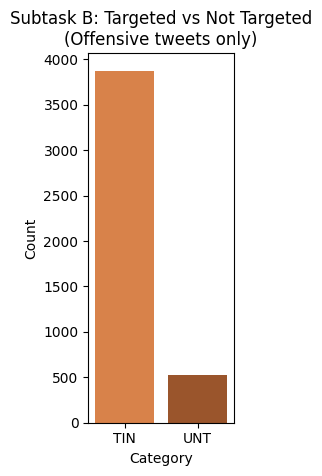

In [10]:
plt.subplot(1, 3, 2)
sns.barplot(x=subtask_b_counts.index, y=subtask_b_counts.values, palette="Oranges_d")
plt.title("Subtask B: Targeted vs Not Targeted\n(Offensive tweets only)")
plt.xlabel("Category")
plt.ylabel("Count")


<ipython-input-11-dd622dadf7f8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subtask_c_counts.index, y=subtask_c_counts.values, palette="Greens_d")


Text(0, 0.5, 'Count')

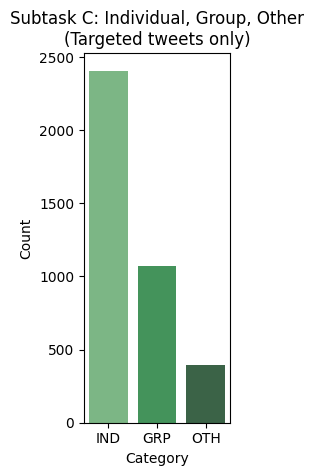

In [11]:
plt.subplot(1, 3, 3)
sns.barplot(x=subtask_c_counts.index, y=subtask_c_counts.values, palette="Greens_d")
plt.title("Subtask C: Individual, Group, Other\n(Targeted tweets only)")
plt.xlabel("Category")
plt.ylabel("Count")


In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# New Section

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [12]:
os.environ["ACCELERATE_USE_FP16"] = "true"  # Enables mixed precision
os.environ["ACCELERATE_MULTI_GPU"] = "true"

# BERT base

**Load and split data**

In [13]:
df = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a"]]
label_map = {"NOT": 0, "OFF": 1}
df["label"] = df["subtask_a"].map(label_map)

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


**Tokenize data**

In [15]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["tweet"])

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10592 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

In [16]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


**Load Model**

In [17]:
# Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define the metrics needed from trainer**

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

**Define Training Arguments**

In [19]:
# Training args
training_args = TrainingArguments(
    output_dir="./bert-offense-detector",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Create trainer**

In [20]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-20-53143a2dc834>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**Run trainer**

In [ ]:
# Train

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kastratj (kastratj-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477300,0.442890,0.801737,0.799949,0.801737,0.793426
2,0.373200,0.480025,0.799849,0.800716,0.799849,0.800252
3,0.305900,0.547965,0.796073,0.797426,0.796073,0.796681


TrainOutput(global_step=1986, training_loss=0.35190060203529194, metrics={'train_runtime': 558.3865, 'train_samples_per_second': 56.907, 'train_steps_per_second': 3.557, 'total_flos': 1314683721429120.0, 'train_loss': 0.35190060203529194, 'epoch': 3.0})

**Print results**

In [ ]:
# Evaluate
results = trainer.evaluate()
print(results)

{'eval_loss': 0.5479651689529419, 'eval_accuracy': 0.7960725075528701, 'eval_precision': 0.7974261692924244, 'eval_recall': 0.7960725075528701, 'eval_f1': 0.7966814649739639, 'eval_runtime': 12.4029, 'eval_samples_per_second': 213.499, 'eval_steps_per_second': 13.384, 'epoch': 3.0}


**The method for subtask b is the same as subtask a**

In [21]:
df_2 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a","subtask_b"]]
df_2 = df_2[df_2["subtask_a"] == "OFF"].copy()
df_2["subtask_b"].fillna("NONE", inplace=True)  # Assign "NONE" to missing values in subtask_b


<ipython-input-21-9bab0cf7d657>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2["subtask_b"].fillna("NONE", inplace=True)  # Assign "NONE" to missing values in subtask_b


In [22]:
label_map = {"NOT": 0, "OFF": 1}
df_2["label"] = df_2["subtask_a"].map(label_map)
label_map_b = {"TIN": 0, "UNT": 1}
df_2["label"] = df_2["subtask_b"].map(label_map_b)

In [23]:
train_df_2, val_df_2 = train_test_split(df_2, test_size=0.2, random_state=42)
train_dataset_2 = Dataset.from_pandas(train_df_2)
val_dataset_2 = Dataset.from_pandas(val_df_2)


In [24]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["tweet"])

train_dataset_2 = train_dataset_2.map(tokenize, batched=True)
val_dataset_2 = val_dataset_2.map(tokenize, batched=True)

Map:   0%|          | 0/3520 [00:00<?, ? examples/s]

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

In [25]:
# Set format for PyTorch
train_dataset_2.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset_2.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [27]:
model_stage2 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
training_args_stage2 = TrainingArguments(
    output_dir="./bert_stage2_targeted",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_stage2",
    fp16=torch.cuda.is_available()
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-29-e6e5dd9624bf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage2 = Trainer(


In [ ]:
trainer_stage2.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.607672,0.871591,0.831745,0.871591,0.834260
2,No log,0.819903,0.870455,0.837521,0.870455,0.843836
3,0.104100,0.865630,0.851136,0.822458,0.851136,0.833582


TrainOutput(global_step=660, training_loss=0.08924282030625777, metrics={'train_runtime': 75.9927, 'train_samples_per_second': 138.961, 'train_steps_per_second': 8.685, 'total_flos': 414325912207680.0, 'train_loss': 0.08924282030625777, 'epoch': 3.0})

In [ ]:
results_stage2 = trainer_stage2.evaluate()
print("🔎 Stage 2 Evaluation:", results_stage2)

🔎 Stage 2 Evaluation: {'eval_loss': 0.3999153971672058, 'eval_accuracy': 0.8704545454545455, 'eval_precision': 0.839417635851793, 'eval_recall': 0.8704545454545455, 'eval_f1': 0.8460661227550718, 'eval_runtime': 1.1826, 'eval_samples_per_second': 744.094, 'eval_steps_per_second': 46.506, 'epoch': 3.0}


In [ ]:
def tokenize_function_c(examples):
    tokenized = tokenizer(examples["tweet"], truncation=True, padding="max_length")
    tokenized["label"] = examples["label"]
    return tokenized

**The code for subtask c is similar to a and b, but with 3 classes instead**

In [30]:
df_3 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a","subtask_b","subtask_c"]]
df_3 = df_3[df_3["subtask_b"] == "TIN"].copy()
df_3["subtask_c"].fillna("NONE", inplace=True)  # Assign "NONE" to missing values in subtask_b


<ipython-input-30-1401551d4b68>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_3["subtask_c"].fillna("NONE", inplace=True)  # Assign "NONE" to missing values in subtask_b


In [31]:
label_map_c = {"IND": 0, "GRP": 1, "OTH": 2}
df_3["label"] = df_3["subtask_c"].map(label_map_c)


In [32]:
train_df_3, val_df_3 = train_test_split(df_3, test_size=0.2, random_state=42)
train_dataset_3 = Dataset.from_pandas(train_df_3)
val_dataset_3 = Dataset.from_pandas(val_df_3)


In [33]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["tweet"])

train_dataset_3 = train_dataset_3.map(tokenize, batched=True)
val_dataset_3 = val_dataset_3.map(tokenize, batched=True)

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

In [34]:
# Set format for PyTorch
train_dataset_3.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset_3.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


**Number of labels increased to 3**

In [35]:
model_stage3 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [37]:
training_args_stage3 = TrainingArguments(
    output_dir="./bert_stage3_target_type",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_stage3",
    fp16=torch.cuda.is_available()
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
trainer_stage3 = Trainer(
    model=model_stage3,
    args=training_args_stage3,
    train_dataset=train_dataset_3,
    eval_dataset=val_dataset_3,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-38-4e8213592277>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage3 = Trainer(


In [ ]:
trainer_stage3.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.634514,0.748711,0.683872,0.748711,0.714344
2,No log,0.635359,0.756443,0.740736,0.756443,0.731254
3,0.651100,0.637349,0.762887,0.737104,0.762887,0.736903


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=582, training_loss=0.6314594819373691, metrics={'train_runtime': 72.4294, 'train_samples_per_second': 128.401, 'train_steps_per_second': 8.035, 'total_flos': 368367007113504.0, 'train_loss': 0.6314594819373691, 'epoch': 3.0})

In [ ]:
results_stage3 = trainer_stage3.evaluate()
print("🔎 Stage 3 Evaluation:", results_stage3)

🔎 Stage 3 Evaluation: {'eval_loss': 0.6373487710952759, 'eval_accuracy': 0.7628865979381443, 'eval_precision': 0.7371043825707354, 'eval_recall': 0.7628865979381443, 'eval_f1': 0.7369027480002123, 'eval_runtime': 1.0238, 'eval_samples_per_second': 757.977, 'eval_steps_per_second': 47.862, 'epoch': 3.0}


# BERT Tweet

**The code for the BERTweet section is similar to the BERT section, with minor changes**

In [39]:
df_4 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a"]]
label_map_a = {"OFF": 1, "NOT": 0}
df_4["label"] = df_4["subtask_a"].map(label_map_a)


In [40]:
train_df_4, val_df_4 = train_test_split(df_4, test_size=0.2, random_state=42)
train_dataset_4 = Dataset.from_pandas(train_df_4)
val_dataset_4 = Dataset.from_pandas(val_df_4)


**Tokenizer is now BERTweet**

In [41]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

def tokenize(example):
    return tokenizer(example["tweet"])

train_dataset_4 = train_dataset_4.map(tokenize, batched=True)
val_dataset_4 = val_dataset_4.map(tokenize, batched=True)

Map:   0%|          | 0/10592 [00:00<?, ? examples/s]

Map:   0%|          | 0/2648 [00:00<?, ? examples/s]

In [42]:
# Set format for PyTorch
train_dataset_4.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset_4.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

**Model is now BERTweet**

In [43]:
model_stage4 = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
training_args_4 = TrainingArguments(
    output_dir="./bertweet_stage1_offensiveness",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_stage1_bt",
    fp16=torch.cuda.is_available()
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [45]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }



In [46]:
trainer_stage4 = Trainer(
    model=model_stage4,
    args=training_args_4,
    train_dataset=train_dataset_4,
    eval_dataset=val_dataset_4,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-46-1c8865b2e064>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage4 = Trainer(


In [ ]:
trainer_stage4.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kastratj (kastratj-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.447918,0.800982,0.800648,0.800982,0.791200
2,0.484100,0.434578,0.804758,0.807099,0.804758,0.805729
3,0.484100,0.455244,0.812689,0.813506,0.812689,0.813066


TrainOutput(global_step=993, training_loss=0.41189957817515577, metrics={'train_runtime': 558.0714, 'train_samples_per_second': 56.939, 'train_steps_per_second': 1.779, 'total_flos': 5506665934484736.0, 'train_loss': 0.41189957817515577, 'epoch': 3.0})

In [ ]:

results_4 = trainer_stage4.evaluate()
print("📊 Stage 1 (BERTweet) Results:", results_4)

📊 Stage 1 (BERTweet) Results: {'eval_loss': 0.4552437961101532, 'eval_accuracy': 0.8126888217522659, 'eval_precision': 0.8135057067275099, 'eval_recall': 0.8126888217522659, 'eval_f1': 0.8130662264093035, 'eval_runtime': 9.3628, 'eval_samples_per_second': 282.822, 'eval_steps_per_second': 8.865, 'epoch': 3.0}


In [47]:
df_5 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a", "subtask_b"]]
df_5 = df_5[df_5["subtask_a"] == "OFF"].copy()
df_5["subtask_b"].fillna("NONE", inplace=True)


<ipython-input-47-36caabb38d5a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_5["subtask_b"].fillna("NONE", inplace=True)


In [48]:
label_map_b = {"TIN": 0, "UNT": 1}
df_5["label"] = df_5["subtask_b"].map(label_map_b)

In [49]:
train_df_5, val_df_5 = train_test_split(df_5, test_size=0.2, random_state=42)
train_dataset_5 = Dataset.from_pandas(train_df_5)
val_dataset_5 = Dataset.from_pandas(val_df_5)


In [50]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

def tokenize(example):
    return tokenizer(example["tweet"])

train_dataset_5 = train_dataset_5.map(tokenize, batched=True)
val_dataset_5 = val_dataset_5.map(tokenize, batched=True)

Map:   0%|          | 0/3520 [00:00<?, ? examples/s]

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

In [51]:
# Set format for PyTorch
train_dataset_5.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset_5.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [52]:
model_stage5 = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
training_args_5 = TrainingArguments(
    output_dir="./bertweet_stage2_targeted",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_stage2_bt",
    fp16=torch.cuda.is_available()
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:
trainer_stage5 = Trainer(
    model=model_stage5,
    args=training_args_5,
    train_dataset=train_dataset_5,
    eval_dataset=val_dataset_5,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-54-54429c0ca413>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage5 = Trainer(


In [ ]:
trainer_stage5.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.336677,0.872727,0.761653,0.872727,0.813416
2,No log,0.422239,0.873864,0.837488,0.873864,0.822251
3,0.347800,0.375567,0.870455,0.842216,0.870455,0.849192


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=660, training_loss=0.32882644190932764, metrics={'train_runtime': 241.3458, 'train_samples_per_second': 43.755, 'train_steps_per_second': 2.735, 'total_flos': 1504719677513472.0, 'train_loss': 0.32882644190932764, 'epoch': 3.0})

In [55]:
results_5 = trainer_stage5.evaluate()
print("📊 Stage 2 (BERTweet) Results:", results_5)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kastratj (kastratj-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


📊 Stage 2 (BERTweet) Results: {'eval_loss': 0.5049149990081787, 'eval_model_preparation_time': 0.006, 'eval_accuracy': 0.8727272727272727, 'eval_precision': 0.7616528925619834, 'eval_recall': 0.8727272727272727, 'eval_f1': 0.8134157105030891, 'eval_runtime': 3.2066, 'eval_samples_per_second': 274.436, 'eval_steps_per_second': 17.152}


In [56]:
df_6 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a", "subtask_b", "subtask_c"]]
df_6["subtask_c"].fillna("NONE", inplace=True)  # Fill NAs
df_6 = df_6[df_6["subtask_b"] == "TIN"].copy()  # Only TIN tweets

<ipython-input-56-c26beca456be>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_6["subtask_c"].fillna("NONE", inplace=True)  # Fill NAs


In [57]:
label_map_c = {"IND": 0, "GRP": 1, "OTH": 2}
df_6["label"] = df_6["subtask_c"].map(label_map_c)

In [58]:
train_df_6, val_df_6 = train_test_split(df_6, test_size=0.2, random_state=42)
train_dataset_6 = Dataset.from_pandas(train_df_6)
val_dataset_6 = Dataset.from_pandas(val_df_6)


In [59]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

def tokenize(example):
    return tokenizer(example["tweet"], padding="max_length", truncation=True, max_length=128)

train_dataset_6 = train_dataset_6.map(tokenize, batched=True)
val_dataset_6 = val_dataset_6.map(tokenize, batched=True)

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

In [60]:
# Set format for PyTorch
train_dataset_6.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset_6.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [61]:

model_stage6 = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=3)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
training_args_6 = TrainingArguments(
    output_dir="./bertweet_stage3",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_bertweet_stage3",
    fp16=torch.cuda.is_available()
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [64]:
trainer_stage6 = Trainer(
    model=model_stage6,
    args=training_args_6,
    train_dataset=train_dataset_6,
    eval_dataset=val_dataset_6,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-64-7b3c7a2a72b4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage6 = Trainer(


In [65]:
trainer_stage6.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.652510,0.729381,0.669921,0.729381,0.697365
2,No log,0.619879,0.747423,0.695973,0.747423,0.717220
3,0.740500,0.647915,0.728093,0.676262,0.728093,0.699120


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=582, training_loss=0.716746654707132, metrics={'train_runtime': 266.6033, 'train_samples_per_second': 34.883, 'train_steps_per_second': 2.183, 'total_flos': 2166747740697600.0, 'train_loss': 0.716746654707132, 'epoch': 3.0})

In [66]:
results_6 = trainer_stage6.evaluate()
print("📊 BERTweet Stage 3 Results:", results_6)

📊 BERTweet Stage 3 Results: {'eval_loss': 0.6479151248931885, 'eval_accuracy': 0.7280927835051546, 'eval_precision': 0.676261629294439, 'eval_recall': 0.7280927835051546, 'eval_f1': 0.6991195790009048, 'eval_runtime': 3.8587, 'eval_samples_per_second': 201.103, 'eval_steps_per_second': 12.699, 'epoch': 3.0}


# RoBERTa

**Subtask a**

In [67]:
df_7 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")[["tweet", "subtask_a"]]
label_map_7 = {"OFF": 0, "NOT": 1}
df_7["label"] = df_7["subtask_a"].map(label_map_7)

In [68]:
test_texts = df_7["tweet"].tolist()
test_labels = df_7["label"].tolist()

In [69]:
class_names = ["offensive tweet", "not offensive tweet"]  # Mapped from OFF and NOT

In [70]:
olid_dataset = {
    "name": "OLID-Offensive Classification",
    "test_texts": test_texts,
    "test_labels": test_labels,
    "class_names": class_names,
}

**Define the function for running the roberta model for subtask a**

In [71]:
def evaluate_huggingface(dataset, model="roberta"):
    if model == "base":
        classifier = pipeline("zero-shot-classification", device=0)
    else:
        classifier = pipeline("zero-shot-classification", model="roberta-large-mnli", device=0)

    correct = 0
    predictions, gold_labels = [], []

    for text, gold_label_idx in tqdm(zip(dataset["test_texts"], dataset["test_labels"]), total=len(dataset["test_texts"])):
        result = classifier(text, dataset["class_names"], multi_label=False)
        predicted_label = result["labels"][0]
        gold_label = dataset["class_names"][gold_label_idx]

        predictions.append(predicted_label)
        gold_labels.append(gold_label)

        if predicted_label == gold_label:
            correct += 1

    accuracy = correct / len(predictions)
    return accuracy

**Run function**

In [72]:
print("Running RoBERTa zero-shot classification on OLID...")
acc_roberta = evaluate_huggingface(olid_dataset, model="roberta")
print("✅ RoBERTa Accuracy (Zero-Shot, Renamed Classes):", acc_roberta)

Running RoBERTa zero-shot classification on OLID...


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
  3%|▎         | 396/13240 [00:16<08:41, 24.63it/s]


KeyboardInterrupt: 

**Subtask b**

In [ ]:
# Stage 2 Data Prep
df_8 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")
df_8 = df_8[df_8["subtask_a"] == "OFF"].dropna(subset=["subtask_b"])
label_map_8 = {"UNT": 0, "TIN": 1}
df_8["label"] = df_8["subtask_b"].map(label_map_8)

In [ ]:
stage2_class_names = ["untargeted offense", "targeted offense"]

test_texts2 = df_8["tweet"].tolist()
test_labels2 = df_8["label"].tolist()

In [ ]:

stage2_dataset = {
    "name": "OLID-Targeted Offense Classification",
    "test_texts": test_texts2,
    "test_labels": test_labels2,
    "class_names": stage2_class_names,
}

In [ ]:
print("\nRunning RoBERTa zero-shot classification on OLID Stage 2...")
acc_stage2 = evaluate_huggingface(stage2_dataset, model="roberta")
print("✅ RoBERTa Accuracy (Zero-Shot, Renamed Classes - Stage 2):", acc_stage2)

**Subtask c**

In [73]:
# Stage 3 Data Prep
df_9 = pd.read_csv("olid-training-v1.0.tsv/olid-training-v1.0.tsv", sep="\t")
df_9 = df_9[df_9["subtask_b"] == "TIN"].dropna(subset=["subtask_c"])
label_map_9 = {"IND": 0, "GRP": 1, "OTH": 2}
df_9["label"] = df_9["subtask_c"].map(label_map_9)

In [74]:
stage3_class_names = ["targeted at individual", "targeted at group", "targeted at other"]

train_texts3, test_texts3, train_labels3, test_labels3 = train_test_split(
    df_9["tweet"].tolist(), df_9["label"].tolist(), test_size=0.2, random_state=42
)

In [75]:
stage3_dataset = {
    "name": "OLID-Offense Type Classification",
    "test_texts": test_texts3,
    "test_labels": test_labels3,
    "class_names": stage3_class_names,
}


In [76]:
print("\nRunning RoBERTa zero-shot classification on OLID Stage 3...")
acc_stage3 = evaluate_huggingface(stage3_dataset, model="roberta")
print("✅ RoBERTa Accuracy (Zero-Shot, Renamed Classes - Stage 3):", acc_stage3)


Running RoBERTa zero-shot classification on OLID Stage 3...


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
100%|██████████| 776/776 [00:47<00:00, 16.34it/s]

✅ RoBERTa Accuracy (Zero-Shot, Renamed Classes - Stage 3): 0.6443298969072165
